/var/folders/ml/d5_wdzfx4b94d9n7g5j1wb_80000gn/T/ipykernel_20847/1711865836.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model

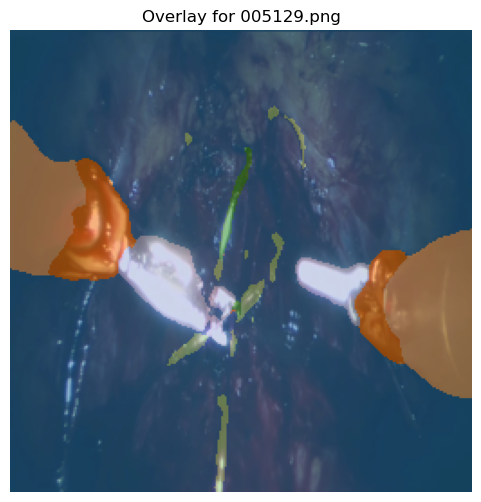

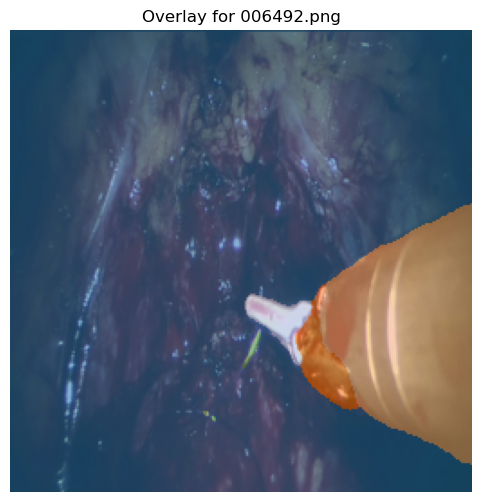

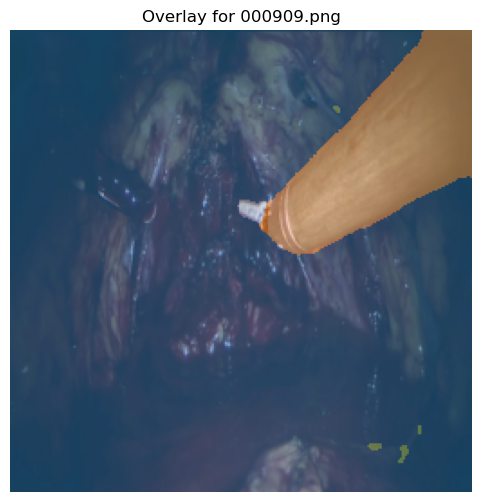

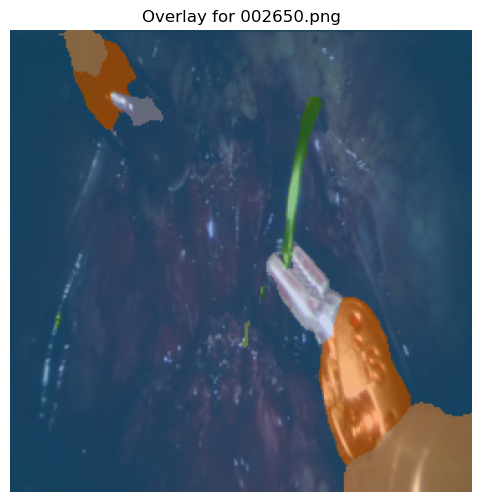

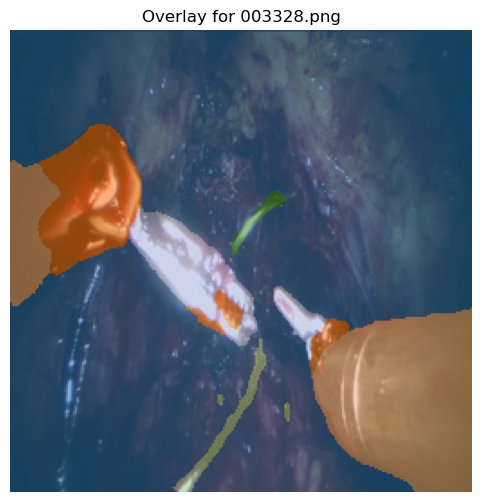

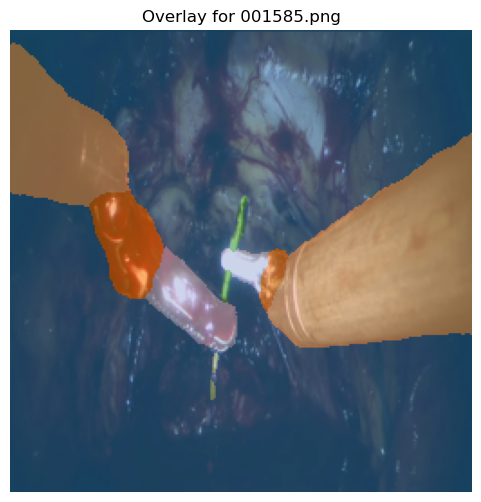

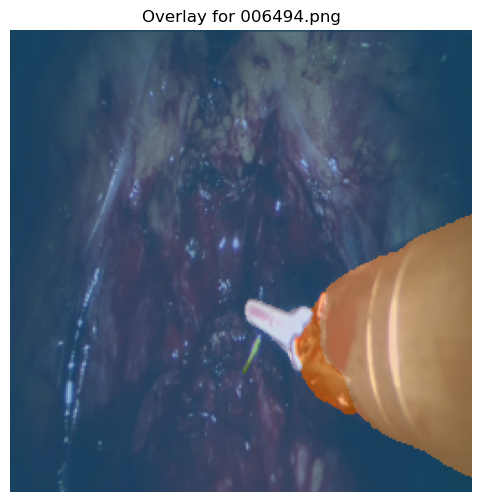

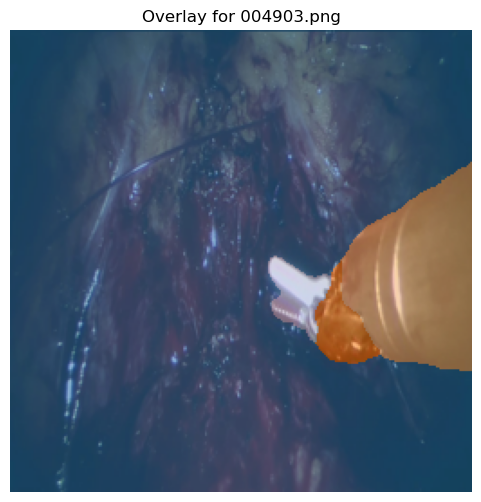

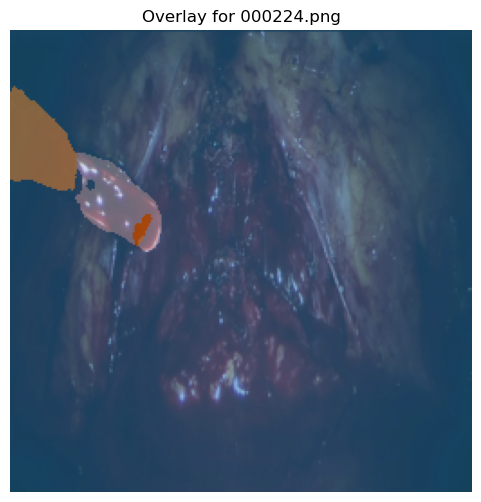

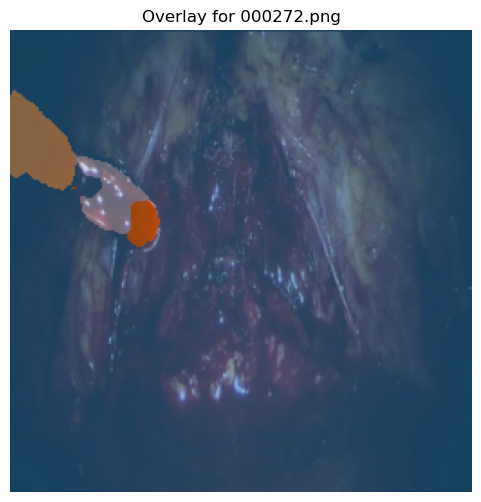

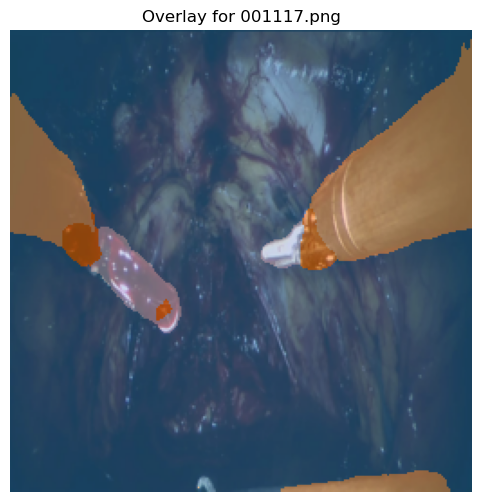

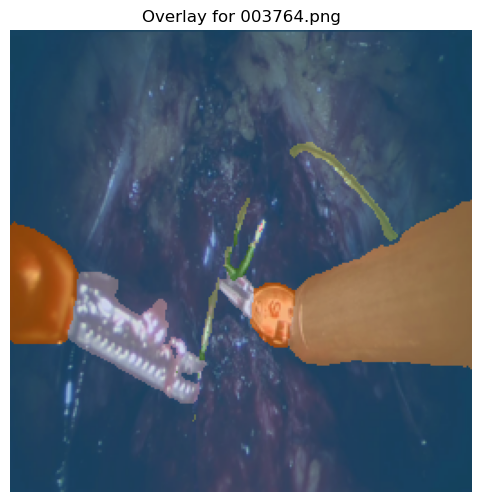

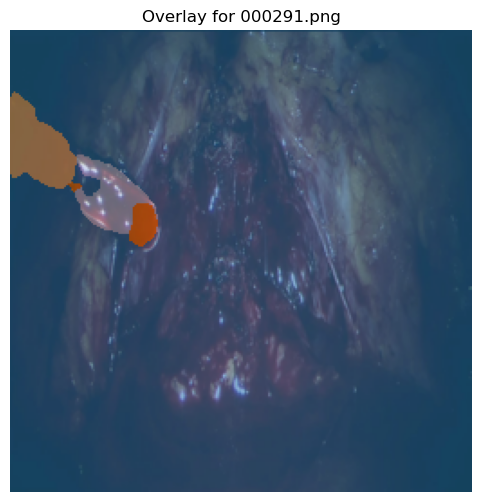

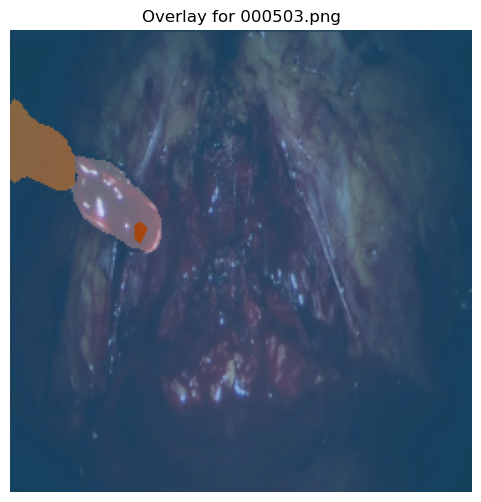

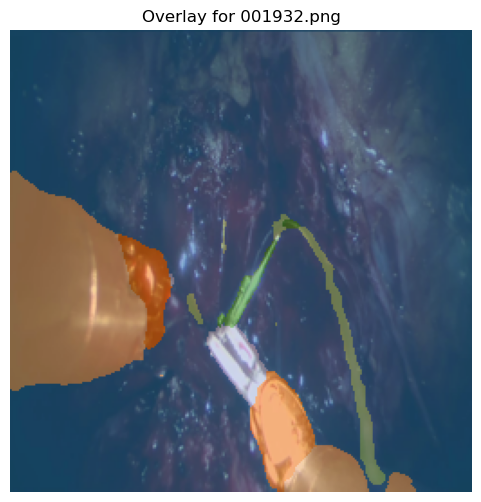

In [12]:
import torch
import segmentation_models_pytorch as smp
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# Define the model architecture
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights=None,  # We don't load pre-trained weights; we load your trained weights
    in_channels=3,
    classes=10  # Update based on your number of classes
)

# Load the trained weights with map_location='cpu' for CPU-only machines
model.load_state_dict(torch.load('best_model10.pth', map_location='cpu'))
model.eval()  # Set the model to evaluation mode

# Define the same transforms used during training
transform = Compose([
    Resize((256, 256)),  # Resize to the input size of the model
    ToTensor(),  # Convert to tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure it's an RGB image
    image = transform(image)
    return image.unsqueeze(0)  # Add batch dimension

def predict(image_path, model):
    # Preprocess the image
    input_tensor = preprocess_image(image_path)
    
    # Run inference
    with torch.no_grad():
        output = model(input_tensor)  # Model prediction
        output = torch.softmax(output, dim=1)  # Apply softmax to get probabilities

    # Convert the prediction to a segmentation map
    output_segmentation = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    return output_segmentation

def overlay_mask(image_path, segmentation_map):
    # Load the original image
    image = Image.open(image_path).convert("RGB")
    image = image.resize((256, 256))  # Resize to ensure the size matches the segmentation map
    # Create an RGBA version of the segmentation map
    rgba_image = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 4), dtype=np.uint8)
    # Use a colormap to generate colors
    cmap = plt.get_cmap("tab20")
    for i in range(10):  # Assuming 10 classes
        rgba_image[segmentation_map == i, :3] = np.array(cmap(i)[:3]) * 255
        rgba_image[segmentation_map == i, 3] = 128  # Set alpha to 128 for visibility
    rgba_segmentation = Image.fromarray(rgba_image)
    rgba_segmentation = rgba_segmentation.resize(image.size)  # Ensure sizes match
    overlay_image = Image.alpha_composite(image.convert("RGBA"), rgba_segmentation)
    return overlay_image

# Path to the directory containing test frames
test_frames_directory = 'test_frames/'

# Select 30 random test frame paths
test_frame_paths = random.sample([
    os.path.join(test_frames_directory, f) for f in os.listdir(test_frames_directory)
    if f.endswith('.png') or f.endswith('.jpg')
], 15)

# Display predictions and overlay images
for path in test_frame_paths:
    segmentation_map = predict(path, model)
    composite_image = overlay_mask(path, segmentation_map)

    # Display the overlay image
    plt.figure(figsize=(6, 6))
    plt.imshow(composite_image)
    plt.title(f"Overlay for {os.path.basename(path)}")
    plt.axis('off')
    plt.show()